In [1]:
import os,random
os.environ["KERAS_BACKEND"] = "tensorflow"
import math
import numpy as np
import matplotlib.pyplot as plt
import random, sys, keras
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import *
from tensorflow.keras.optimizers import Adam


In [2]:
import math
import numpy as np
import random, sys
import matplotlib.pyplot as plt
import _pickle as cPickle

In [3]:
# Load the dataset
#  from a certain local path
Xd = cPickle.load(open("RML2016.10a_dict.pkl",'rb'), encoding='latin1')
print("Dataset imported")
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):
            lbl.append((mod,snr))

X = np.vstack(X)

Dataset imported


In [4]:
# For dataset RML2016.10a_dict, we should have data size 220000*2*128
print ("Dataset formatted into shape: ",X.shape)
# print out the snrs and mods
print ("Dataset with SNRs: ",snrs)
print ("Dataset with Modulations: ",mods)
print ("Data prepared")


Dataset formatted into shape:  (220000, 2, 128)
Dataset with SNRs:  [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]
Dataset with Modulations:  ['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']
Data prepared


In [5]:
# Partition the data
#  into training and test sets of the form we can train/test on 
#  while keeping SNR and Mod labels handy for each
np.random.seed(2017)
n_examples = X.shape[0]
n_train = int(n_examples * 0.5)
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]

In [6]:
def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1

In [7]:
trainy =list(map(lambda x: mods.index(lbl[x][0]), train_idx))
Y_train = to_onehot(trainy)
Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))

In [8]:
in_shp = list(X_train.shape[1:])
# print X_train.shape, in_shp
classes = mods


In [9]:
# Set up some params
nb_epoch = 100     # number of epochs to train on
batch_size = 1024  # training batch size
dr = 0.4 # dropout rate (%)

In [10]:
model = models.Sequential()
model.add(Reshape(in_shp+[1], input_shape=in_shp))
model.add(ZeroPadding2D((0,2)))
# 1st Convolutional Layer
model.add(Conv2D(64, (1,4), activation="relu"))
model.add(Dropout(dr))
# 2nd Convolutional Layer
model.add(Conv2D(64, (2,4), activation="relu")) 
model.add(Dropout(dr))
# 3rd Convolutional Layer
model.add(Conv2D(128, (1,8), activation="relu"))
model.add(Dropout(dr))
# 4th Convolutional Layer
model.add(Conv2D(128, (1,8), activation="relu"))
model.add(Dropout(dr))
# 5th Convolutional Layer
model.add(Conv2D(128, (1,8), activation="relu"))
model.add(Dropout(dr))
 
# Flattening
model.add(Flatten())
  
# 1st Dense Layer
model.add(Dense(256, activation='relu'))
model.add(Dropout(dr))
  
# Output Softmax Layer
model.add(Dense(len(classes), activation='softmax'))
model.add(Reshape([len(classes)]))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 2, 128, 1)         0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 2, 132, 1)        0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 2, 129, 64)        320       
                                                                 
 dropout (Dropout)           (None, 2, 129, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 126, 64)        32832     
                                                                 
 dropout_1 (Dropout)         (None, 1, 126, 64)        0         
                                                        

In [11]:
# Set up some params 
epochs = 11     
batch_size = 1024  

In [12]:
#%%
filepath = "layers.wts.h5" 
history = model.fit(X_train,Y_train,batch_size=batch_size,epochs=epochs,verbose=2,validation_data=(X_test, Y_test),
    callbacks = [ 
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ]) 
model.load_weights(filepath)


Epoch 1/11
108/108 - 1629s - loss: 2.1674 - accuracy: 0.1880 - val_loss: 1.9691 - val_accuracy: 0.2804 - 1629s/epoch - 15s/step
Epoch 2/11
108/108 - 1769s - loss: 1.8453 - accuracy: 0.3117 - val_loss: 1.7772 - val_accuracy: 0.3381 - 1769s/epoch - 16s/step
Epoch 3/11
108/108 - 2158s - loss: 1.6781 - accuracy: 0.3725 - val_loss: 1.6658 - val_accuracy: 0.3701 - 2158s/epoch - 20s/step
Epoch 4/11
108/108 - 1776s - loss: 1.5186 - accuracy: 0.4253 - val_loss: 1.4415 - val_accuracy: 0.4514 - 1776s/epoch - 16s/step
Epoch 5/11
108/108 - 2361s - loss: 1.3953 - accuracy: 0.4647 - val_loss: 1.4096 - val_accuracy: 0.4608 - 2361s/epoch - 22s/step
Epoch 6/11
108/108 - 2134s - loss: 1.3389 - accuracy: 0.4849 - val_loss: 1.3202 - val_accuracy: 0.4982 - 2134s/epoch - 20s/step
Epoch 7/11
108/108 - 1661s - loss: 1.3226 - accuracy: 0.4934 - val_loss: 1.3894 - val_accuracy: 0.4689 - 1661s/epoch - 15s/step
Epoch 8/11
108/108 - 20174s - loss: 1.3054 - accuracy: 0.4990 - val_loss: 1.2849 - val_accuracy: 0.5018 

In [18]:
#%%
score = model.evaluate(X_test, Y_test, verbose=0, batch_size=batch_size)
print(score)

[1.2468061447143555, 0.5233181715011597]


In [19]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

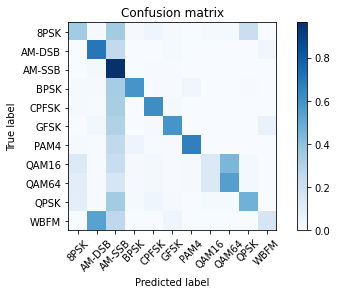

In [20]:
# Plot confusion matrix for the whole dataset
test_Y_hat = model.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1

for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)

Overall Accuracy:  0.08877237389260531
Overall Accuracy:  0.09215262778977681
Overall Accuracy:  0.09672727272727273
Overall Accuracy:  0.10937215650591446
Overall Accuracy:  0.13544141838786328
Overall Accuracy:  0.22002871500358936
Overall Accuracy:  0.3243740795287187
Overall Accuracy:  0.46942765730536795
Overall Accuracy:  0.6006655574043261
Overall Accuracy:  0.7120850907757198
Overall Accuracy:  0.7555271331993422
Overall Accuracy:  0.7571896614488532
Overall Accuracy:  0.7701627486437613
Overall Accuracy:  0.7610846463906192
Overall Accuracy:  0.7633854645814168
Overall Accuracy:  0.7710492816875796
Overall Accuracy:  0.7594754805101491
Overall Accuracy:  0.7644590403211093
Overall Accuracy:  0.7598347404347046
Overall Accuracy:  0.7671986791414419


Text(0.5, 1.0, 'CNN2 Classification Accuracy on RadioML 2016.10 Alpha')

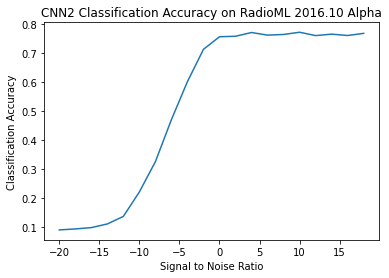

In [22]:

acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
#    print(test_SNRs)
    test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]    

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    #plt.figure()
    #plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print ("Overall Accuracy: ", cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)
#%%
# Plot accuracy curve
plt.plot(snrs, list(map(lambda x: acc[x], snrs)))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha")